In [ ]:
# import all the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
# from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential

In [113]:
!unzip Datasets.zip -d Datasets

Archive:  Datasets.zip
   creating: Datasets/Datasets/Test/
   creating: Datasets/Datasets/Test/audi/
  inflating: Datasets/Datasets/Test/audi/21.jpg  
  inflating: Datasets/Datasets/Test/audi/22.jpg  
  inflating: Datasets/Datasets/Test/audi/23.jpg  
  inflating: Datasets/Datasets/Test/audi/24.jpg  
  inflating: Datasets/Datasets/Test/audi/25.jpg  
  inflating: Datasets/Datasets/Test/audi/26.jpg  
  inflating: Datasets/Datasets/Test/audi/27.jpg  
 extracting: Datasets/Datasets/Test/audi/28.jpg  
  inflating: Datasets/Datasets/Test/audi/29.jpg  
   creating: Datasets/Datasets/Test/lamborghini/
  inflating: Datasets/Datasets/Test/lamborghini/1.jpg  
  inflating: Datasets/Datasets/Test/lamborghini/10.jpg  
  inflating: Datasets/Datasets/Test/lamborghini/11.jpg  
  inflating: Datasets/Datasets/Test/lamborghini/12.jpg  
  inflating: Datasets/Datasets/Test/lamborghini/13.jpg  
  inflating: Datasets/Datasets/Test/lamborghini/14.jpg  
  inflating: Datasets/Datasets/Test/lamborghini/15.jpg  
 

In [ ]:
Image_Size = [224, 224]        # resizing all the image & ( SOTA(State of the art) - takes input as (224, 224))
train_path =  "/content/Train"
test_path = "/content/Test"

 ***"input_shape= Image_Size + [3]". Why " + [3]"?***

It means that the images that we provide to ResNet50, 
is basically have three channels(R-Red, G-Green, B-Blue).

 ***"include_top= False" Why?***

In SOTA of ResNet50 is basically have 1000 categories. But here we use only 3 categories for classification. So, we don't have to include the first and the last.

In [ ]:
# using the imagenet weights

resnet = ResNet50(input_shape= Image_Size + [3], weights= "imagenet", include_top= False)

In [ ]:
## Model summary
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

*** Whatever weights are there in ResNet50, we are going to re-use those.***

This stops any updates to the pre-trained weights during training We do not want to train ResNet layers as we want to leverage the knowledge learned by the deep neural network trained from the previous data set which in our case is “imagenet”

In [ ]:
# we do not train the existing weights.
for layer in resnet.layers:
  layer.trainable = False

In [122]:
# glob - useful for getting number of ouput class
folders = glob("/content/Datasets/Datasets/Train/*")

In [123]:
print(folders)  ## length of the output category for my dataset( in this case- "3")

['/content/Datasets/Datasets/Train/lamborghini', '/content/Datasets/Datasets/Train/mercedes', '/content/Datasets/Datasets/Train/audi']


In [ ]:
# Flatten the ouput
x = Flatten()(resnet.output)

In [124]:
len(folders)

3

*** the output dimension is 3(number of classes).***

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

In [ ]:
# creating the model
model = Model(resnet.input, outputs = prediction)

In [ ]:
## Now, the structure of our model  (see the difference- last layer(flatten and dense))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [126]:
model.compile( loss = "categorical_crossentropy", optimizer= "adam", metrics= ['accuracy'])

**Data augmentation in data analysis are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data. It acts as a regularizer and helps reduce overfitting when training a machine learning model.**

In [125]:
# Using Image Data Generator to import the images from the dataset and applying
# augmentation technique to the images.


train_dataug = ImageDataGenerator(rescale = 1./255,
                                shear_range = 0.2,
                                zoom_range = 0.2,
                                horizontal_flip = True)

test_datan =  ImageDataGenerator(rescale= 1./255)

In [127]:
# preparing the training set with batch size as 32.  /content/Datasets/Datasets
# we have to make sure that the target size have to be same as initialized for the image size.

training_data = train_dataug.flow_from_directory('/content/Datasets/Datasets/Train',
                                                target_size = (224, 224), # here we make sure that
                                                                          # target size is same as initialized 
                                                batch_size = 32,
                                                class_mode = 'categorical')

Found 64 images belonging to 3 classes.


In [128]:
print(training_data.classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [129]:
print(len(training_data.classes))

64


In [130]:
testing_data = test_datan.flow_from_directory('/content/Datasets/Datasets/Test',
                                          target_size = (224,224),
                                          batch_size = 32,
                                          class_mode = 'categorical')

Found 58 images belonging to 3 classes.


In [131]:
print(testing_data.classes)

[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [132]:
print(len(testing_data.classes))

58


In [133]:
# Now, fit the model.

r = model.fit_generator(
    training_data,
    validation_data = testing_data,
    epochs = 200,
    steps_per_epoch = len(training_data),
    validation_steps = len(testing_data)
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
2/2 [==============================] - 76s 11s/step - loss: 6.5049 - accuracy: 0.2188 - val_loss: 4.1742 - val_accuracy: 0.5172
Epoch 2/200
2/2 [==============================] - 14s 10s/step - loss: 6.8230 - accuracy: 0.5156 - val_loss: 1.8044 - val_accuracy: 0.3621
Epoch 3/200
2/2 [==============================] - 14s 10s/step - loss: 2.3270 - accuracy: 0.4531 - val_loss: 6.7085 - val_accuracy: 0.1552
Epoch 4/200
2/2 [==============================] - 14s 10s/step - loss: 5.1974 - accuracy: 0.3281 - val_loss: 3.1409 - val_accuracy: 0.5172
Epoch 5/200
2/2 [==============================] - 14s 10s/step - loss: 2.7132 - accuracy: 0.3906 - val_loss: 3.4071 - val_accuracy: 0.3276
Epoch 6/200
2/2 [==============================] - 14s 10s/step - loss: 3.4354 - accuracy: 0.3906 - val_loss: 3.6259 - val_accuracy: 0.3276
Epoch 7/200
2/2 [==============================] - 14s 10s/step - loss: 2.0112 - accuracy: 0.5156 - val_loss: 2.8635 - val_accuracy: 0.1724
Epoch 8/200
2/2 [===

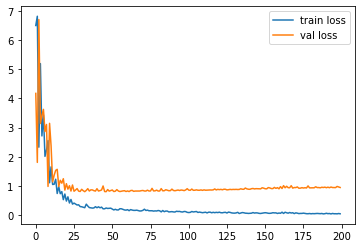

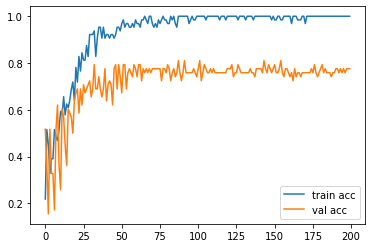

In [134]:
# Loss plot
plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'val loss')
plt.legend()
plt.show()

# Accuracy plot
plt.plot(r.history['accuracy'], label = 'train acc')
plt.plot(r.history['val_accuracy'], label = 'val acc')
plt.legend()
plt.show()

In [135]:
# save this model as a .h5 file
from tensorflow.keras.models import load_model

model.save('car_brand_model_resnet50.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [136]:
# prediction on test data set
y_pred = model.predict(testing_data)

In [137]:
y_pred  # This is typically probabilty based on the three classes, for every image on the test data.

array([[3.74703063e-03, 8.63855705e-04, 9.95389104e-01],
       [1.23956904e-01, 1.67528123e-01, 7.08514988e-01],
       [9.80066299e-01, 1.56982671e-02, 4.23541293e-03],
       [1.60421326e-03, 9.98373151e-01, 2.25833046e-05],
       [2.21698591e-03, 5.03657937e-01, 4.94125038e-01],
       [2.27773543e-02, 2.73434296e-02, 9.49879169e-01],
       [9.98634517e-01, 8.77099868e-04, 4.88368445e-04],
       [1.26186702e-02, 4.81848955e-01, 5.05532324e-01],
       [8.25191319e-01, 7.43512288e-02, 1.00457430e-01],
       [2.23116055e-02, 3.79230708e-01, 5.98457694e-01],
       [7.54605904e-02, 8.93608510e-01, 3.09308730e-02],
       [9.24670517e-01, 7.51472563e-02, 1.82213640e-04],
       [4.71476791e-03, 9.69543874e-01, 2.57413033e-02],
       [8.88841987e-01, 9.40446332e-02, 1.71133783e-02],
       [1.78466405e-04, 9.99560416e-01, 2.61051318e-04],
       [3.64056286e-05, 9.99123752e-01, 8.39826127e-04],
       [5.46671264e-02, 4.63201880e-01, 4.82131004e-01],
       [5.49975177e-03, 9.88637

In [138]:
len(y_pred)

58

In [139]:
y_pred = np.argmax(y_pred, axis = 1)

In [140]:
y_pred

array([2, 2, 0, 1, 1, 2, 0, 2, 0, 2, 1, 0, 1, 0, 1, 1, 2, 1, 1, 2, 1, 2,
       1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 0, 2, 2, 1, 1, 1, 1,
       1, 1, 2, 1, 2, 1, 0, 1, 1, 2, 0, 1, 1, 1])

***Test on a new data***

In [238]:
img = image.load_img('/content/a.jpg', target_size=(224,224))  

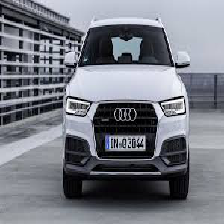

In [239]:
img

In [240]:
x = image.img_to_array(img)
x

array([[[ 64.,  64.,  72.],
        [ 36.,  36.,  44.],
        [ 39.,  39.,  47.],
        ...,
        [200., 206., 220.],
        [200., 206., 220.],
        [200., 206., 220.]],

       [[121., 121., 129.],
        [ 89.,  89.,  97.],
        [ 74.,  74.,  82.],
        ...,
        [199., 205., 219.],
        [199., 205., 219.],
        [199., 205., 219.]],

       [[121., 121., 129.],
        [ 89.,  89.,  97.],
        [ 74.,  74.,  82.],
        ...,
        [199., 205., 219.],
        [199., 205., 219.],
        [199., 205., 219.]],

       ...,

       [[167., 170., 175.],
        [164., 167., 172.],
        [163., 166., 171.],
        ...,
        [163., 166., 171.],
        [163., 166., 171.],
        [162., 165., 170.]],

       [[167., 170., 175.],
        [164., 167., 172.],
        [163., 166., 171.],
        ...,
        [163., 166., 171.],
        [163., 166., 171.],
        [162., 165., 170.]],

       [[170., 173., 178.],
        [168., 171., 176.],
        [166., 1

In [241]:
x.shape

(224, 224, 3)

In [242]:
x = x /255

In [243]:
x

array([[[0.2509804 , 0.2509804 , 0.28235295],
        [0.14117648, 0.14117648, 0.17254902],
        [0.15294118, 0.15294118, 0.18431373],
        ...,
        [0.78431374, 0.80784315, 0.8627451 ],
        [0.78431374, 0.80784315, 0.8627451 ],
        [0.78431374, 0.80784315, 0.8627451 ]],

       [[0.4745098 , 0.4745098 , 0.5058824 ],
        [0.34901962, 0.34901962, 0.38039216],
        [0.2901961 , 0.2901961 , 0.32156864],
        ...,
        [0.78039217, 0.8039216 , 0.85882354],
        [0.78039217, 0.8039216 , 0.85882354],
        [0.78039217, 0.8039216 , 0.85882354]],

       [[0.4745098 , 0.4745098 , 0.5058824 ],
        [0.34901962, 0.34901962, 0.38039216],
        [0.2901961 , 0.2901961 , 0.32156864],
        ...,
        [0.78039217, 0.8039216 , 0.85882354],
        [0.78039217, 0.8039216 , 0.85882354],
        [0.78039217, 0.8039216 , 0.85882354]],

       ...,

       [[0.654902  , 0.6666667 , 0.6862745 ],
        [0.6431373 , 0.654902  , 0.6745098 ],
        [0.6392157 , 0

In [244]:
x = np.expand_dims(x, axis = 0)
im_data = preprocess_input(x)
im_data.shape

(1, 224, 224, 3)

In [245]:
p = np.argmax(model.predict(im_data),axis =1)  # predicted- 0th index, that means- Audi
p                                              # actual - Audi

array([0])